# Question Answering with a Fine-Tuned BERT
*by Chris McCormick*

What does it mean for BERT to achieve "human-level performance on Question Answering"? Is BERT the greatest search engine ever, able to find the answer to any question we pose it?

In **Part 1** of this post / notebook, I'll explain what it really means to apply BERT to QA, and illustrate the details.

**Part 2** contains example code--we'll be downloading a model that's *already been fine-tuned* for question answering, and try it out on our own text! 

For something like text classification, you definitely want to fine-tune BERT on your own dataset. For question answering, however, it seems like you may be able to get decent results using a model that's already been fine-tuned on the SQuAD benchmark. In this Notebook, we'll do exactly that, and see that it performs well on text that wasn't in the SQuAD dataset.

**Links**

* My [video walkthrough](https://youtu.be/l8ZYCvgGu0o) on this topic. 
* The blog post version.
* The [Colab Notebook](https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-).

# Part 1: How BERT is applied to Question Answering

## The SQuAD v1.1 Benchmark

When someone mentions "Question Answering" as an application of BERT, what they are really referring to is applying BERT to the Stanford Question Answering Dataset (SQuAD).

The task posed by the SQuAD benchmark is a little different than you might think. Given a question, and *a passage of text containing the answer*, BERT needs to highlight the "span" of text corresponding to the correct answer. 

The SQuAD homepage has a fantastic tool for exploring the questions and reference text for this dataset, and even shows the predictions made by top-performing models.

For example, here are some [interesting examples](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1) on the topic of Super Bowl 50.


## BERT Input Format

To feed a QA task into BERT, we pack both the question and the reference text into the input.

![Input format for QA](http://www.mccormickml.com/assets/BERT/SQuAD/input_formatting.png)

The two pieces of text are separated by the special `[SEP]` token. 

BERT also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B") that BERT learned, and which it adds to the token embeddings before feeding them into the input layer. 

## Start & End Token Classifiers

BERT needs to highlight a "span" of text containing the answer--this is represented as simply predicting which token marks the start of the answer, and which token marks the end.

![Start token classification](http://www.mccormickml.com/assets/BERT/SQuAD/start_token_classification.png)

For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue "start" rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the 'start' weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token--we have a separate weight vector this.

![End token classification](http://www.mccormickml.com/assets/BERT/SQuAD/end_token_classification.png)

# Part 2: Example Code

In the example code below, we'll be downloading a model that's *already been fine-tuned* for question answering, and try it out on our own text.

If you do want to fine-tune on your own dataset, it is possible to fine-tune BERT for question answering yourself. See [run_squad.py](https://github.com/huggingface/transformers/blob/master/examples/run_squad.py) in the `transformers` library. However,you may find that the below "fine-tuned-on-squad" model already does a good job, even if your text is from a different domain. 

> Note: The example code in this Notebook is a commented and expanded version of the short example provided in the `transformers` documentation [here](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering).

## 1. Install huggingface transformers library

This example uses the `transformers` [library](https://github.com/huggingface/transformers/) by huggingface. We'll start by installing the package.

## 2. Load Fine-Tuned BERT-large

For Question Answering we use the `BertForQuestionAnswering` class from the `transformers` library.

This class supports fine-tuning, but for this example we will keep things simpler and load a BERT model that has already been fine-tuned for the SQuAD benchmark.

The `transformers` library has a large collection of pre-trained models which you can reference by name and load easily. The full list is in their documentation [here](https://huggingface.co/transformers/pretrained_models.html).

For Question Answering, they have a version of BERT-large that has already been fine-tuned for the SQuAD benchmark. 

BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance. 

(Note that this download is not using your own network bandwidth--it's between the Google instance and wherever the model is stored on the web).

Note: I believe this model was trained on version 1 of SQuAD, since it's not outputting whether the question is "impossible" to answer from the text (which is part of the task in v2 of SQuAD).


In [1]:
## Cross Entropy Loss with Label Smoothing

#Loss function to penalize far predictions more than close ones.
import torch
# Example Usage:- smooth_one_hot(torch.tensor([2, 3]), classes=10, smoothing=0.1)
def smooth_one_hot(true_labels: torch.Tensor, classes: int, smoothing=0.0):
    """
  if smoothing == 0, it's one-hot method
  if 0 < smoothing < 1, it's smooth method
  """
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    #print(f"Confidence:{confidence}")
    label_shape = torch.Size((true_labels.size(0), classes))
    #print(f"Label Shape:{label_shape}")
    with torch.no_grad():
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        #print(f"True Distribution:{true_dist}")
        true_dist.fill_(smoothing / (classes - 1))
        #print(f"First modification to True Distribution:{true_dist}")
        true_dist.scatter_(1, true_labels.data.unsqueeze(1), confidence)
    #print(f"Modified Distribution:{true_dist}")
    return true_dist

def cross_entropy(input, target, size_average=True):
    """ Cross entropy that accepts soft targets
  Args:
        pred: predictions for neural network
        targets: targets, can be soft
        size_average: if false, sum is returned instead of mean
  """
    logsoftmax = nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))
      
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    
    smooth_start_positions = smooth_one_hot(start_positions, classes=384, smoothing=0.1)
    smooth_end_positions = smooth_one_hot(end_positions, classes=384, smoothing=0.1)

    start_loss = cross_entropy(start_logits, smooth_start_positions)
    end_loss = cross_entropy(end_logits, smooth_end_positions)
    total_loss = (start_loss + end_loss)
  
    return total_loss

In [2]:
import numpy as np
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import Optional, Tuple
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer,BertPreTrainedModel,BertModel,BertTokenizer
from transformers.modeling_outputs import QuestionAnsweringModelOutput

 
@dataclass        
class QuestionAnsweringModelOutputWithMultiTask(QuestionAnsweringModelOutput):
    loss: Optional[torch.FloatTensor] = None
    classifed_logits: torch.FloatTensor = None
    start_logits: torch.FloatTensor = None
    end_logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


class BertForQuestionAnsweringWithMultiTask(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)
        self.span_classifier = nn.Linear(config.hidden_size*2, config.num_labels)
        self.include_classifier = nn.Linear(config.hidden_size, config.num_labels)
        assert config.num_labels == 2
        self.high_dropout = nn.Dropout(p=0.5) 
        self.dropout = nn.Dropout(p=0.2) 
        torch.nn.init.normal_(self.span_classifier.weight, std=0.02)
        torch.nn.init.normal_(self.include_classifier.weight, std=0.02)
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids= None,
        labels=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
       
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states = True,
            return_dict= True,
        )
        
        span_hidden_states = bert_output.hidden_states # (batch_size, sequence_length, hidden_size)
        pooled_output = bert_output.pooler_output # (batch_size, sequence_length, hidden_size)
        pooled_output = self.dropout(pooled_output)
        include_logits = self.include_classifier(pooled_output)
        #include_logits = torch.mean(torch.stack([ self.include_classifier(self.high_dropout(pooled_output))for _ in range(5) ], dim=0), dim=0)
        ###################### Classifier ###################################################################################
        #include_hidden_states = bert_output.hidden_states
        #include_out = torch.stack((include_hidden_states[-1], include_hidden_states[-2],include_hidden_states[-3], include_hidden_states[-4]), dim=0)  #最后四层拼接
        #include_out_mean = torch.mean(include_out, dim=0)
        #include_out_max, _ = torch.max(include_out, dim=0)
        #include_out = torch.cat((include_out_mean, include_out_max), dim=-1)
        #include_logits = torch.mean(torch.stack([ self.include_classifier(self.high_dropout(include_out))for _ in range(4) ], dim=0), dim=0)
        #print(include_logits.shape)
        #################################### Span #############################################################################
        span_out = torch.stack((span_hidden_states[-1], span_hidden_states[-2], span_hidden_states[-3], span_hidden_states[-4]), dim=0)  #最后四层拼接
        span_out_mean = torch.mean(span_out, dim=0)
        span_out_max, _ = torch.max(span_out, dim=0)
        span_out = torch.cat((span_out_mean, span_out_max), dim=-1)
        span_logits = torch.mean(torch.stack([ self.span_classifier(self.high_dropout(span_out))for _ in range(5) ], dim=0), dim=0)
        #print(span_logits)
        #######################################################################################################################
        start_logits, end_logits = span_logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)  # (bs, max_query_len)
        end_logits = end_logits.squeeze(-1)  # (bs, max_query_len)
    
        total_loss = None
        if start_positions is not None and end_positions is not None and labels is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)

            #sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            #loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            #start_loss = loss_fct(start_logits, start_positions)
            #end_loss = loss_fct(end_logits, end_positions)
            span_loss = loss_fn(start_logits, end_logits, start_positions, end_positions)
            include_loss = nn.CrossEntropyLoss()(include_logits, labels)
            #total_loss = (start_loss + end_loss) / 2 + include_loss 
            total_loss = span_loss + include_loss
        return QuestionAnsweringModelOutputWithMultiTask(
                        loss= total_loss,
                        start_logits=start_logits,
                        end_logits=end_logits,
                        classifed_logits = include_logits  ,
                        hidden_states= bert_output.hidden_states,
                        attentions= bert_output.attentions  )
            
        

Load the tokenizer as well. 

Side note: Apparently the vocabulary of this model is identicaly to the one in bert-base-uncased. You can load the tokenizer from `bert-base-uncased` and that works just as well.

In [3]:
path = r'C:\Users\Administrator\Desktop\2021.01.18 question_answering based BERT\test-squad-trained'
tokenizer = BertTokenizer.from_pretrained(path)
model = BertForQuestionAnsweringWithMultiTask.from_pretrained(path)
model.eval()

BertForQuestionAnsweringWithMultiTask(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(26560, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Ask a Question

Now we're ready to feed in an example!

A QA example consists of a question and a passage of text containing the answer to that question.

Let's try an example using the text in this tutorial!

In [4]:
def answerQuestion(question, paper):
    """
    This funtion provides the best answer found by the Q&A model, the chunk containing it
    among all chunks of the input paper and the score obtained by the answer.
    该方法提供了问答模型找到的最佳答案，在所有输入chunk中包含该答案的chunks，以及由该答案得到的分数（置信度）。
    """
    paper = [paragraph for paragraph in paper if len(paragraph)>0]
    inputs = [tokenizer.encode_plus(
        question, paragraph.replace('\n','').replace('\t','').replace(' ',''), 
               add_special_tokens=True, return_tensors="pt") for paragraph in paper ]
    answers = []
    confidence_scores = []
    for n, Input in enumerate(inputs):
        input_ids = Input['input_ids'].to(torch_device)
        token_type_ids = Input['token_type_ids'].to(torch_device)
        attention_masks = Input['attention_mask'].to(torch_device)
        if len(input_ids[0]) > 512:
            input_ids = input_ids[:, :512]
            token_type_ids = token_type_ids[:, :512]
            attention_masks = attention_masks[:, :512]
            
        text_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        outputs = model(    input_ids,
                            token_type_ids =token_type_ids,
                            attention_mask = attention_masks  
                                              )
        
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits
        answer_start = torch.argmax(start_scores)
        answer_end = torch.argmax(end_scores)
        
        # 如果答案的起始标记包含在问题中，起始标记就会被移动到该chunk的第一个。
        check = text_tokens.index("[SEP]")
        if int(answer_start) <= check:
            answer_start = check+1
        answer = tokenizer.convert_tokens_to_string(text_tokens[answer_start:(answer_end+1)])
        answer = answer.replace('[SEP]', '')
        confidence = start_scores[0][answer_start] + end_scores[0][answer_end]
        if answer.startswith('。') or answer.startswith('，'):
            answer = answer[2:]
        answers.append(answer)
        confidence_scores.append(float(confidence))
    
    maxIdx = np.argmax(confidence_scores)
    confidence = confidence_scores[maxIdx]
    best_answer = answers[maxIdx]
    best_paragraph = paper[maxIdx]

    return best_answer.replace(' ',''), confidence, best_paragraph.replace(' ','')

In [5]:
answer_text = ['''“百度”二字，来自于八百年前南宋词人辛弃疾的一句词：众里寻他千百度。这句话描述了词人对理想的执着追求。
1999年底，身在美国硅谷的李彦宏看到了中国互联网及中文搜索引擎服务的巨大发展潜力，抱着技术改变世界的梦想，他毅然辞掉硅谷的高薪工作，携搜索引擎专利技术，
于 2000年1月1日在中关村创建了百度公司。 ''']

question = '''“百度”的典故出自哪里？'''
#question = '''“百度”二字出自哪里？'''

In [6]:
answer_text = ['''百度是全球最大的中文搜索引擎，是中国最大的以信息和知识为核心的互联网综合服务公司，更是全球领先的人工智能平台型公司。
2000年1月1日创立于中关村，公司创始人李彦宏拥有“超链分析”技术专利，也使中国成为美国、俄罗斯、和韩国之外，全球仅有的4个拥有搜索引擎核心技术的国家之一。''']

question = '''百度是什么类型的公司？'''


In [7]:
answer_text = [ '''达观数据是中国文本智能处理企业，利用文字语义自动分析技术，提供文本自动抽取、审核、纠错、搜索、推荐、写作等智能软件系统，让计算机代替人工完成业务流程自动化，提高企业效率。 
        达观团队由来自腾讯、盛大、百度、阿里等知名企业的高管和技术专家组成 ，以及复旦交大同济等高校的科研精英组成，
        多次获国际ACM顶级数据挖掘竞赛的冠亚军等，申请有20余项发明专利， 并先后获得了真格基金，软银赛富，方广资本等机构的投资。
        达观数据已经为华为、招商银行 、中兴等大型企业以及36氪、顺丰海淘、么么直播、梨视频、酷六、界面新闻、趣头条、暴走漫画等；在新媒体的文本挖掘和用户画像方面，达观服务了Papi酱、“一条”等知名客户。
        ''',
               '''2018年，达观数据获阿里巴巴全球诸神之战创客大赛总决赛季军；入选2019年度上海市科技小巨人培育企业；2019年斩获年度最佳RPA行业贡献企业 ；斩获2019全球金融科技创业大赛十强；斩获2019年CCKS中国知识图谱与语义计算大赛亚军；斩获“莱斯杯”全国第一届“军事智能·机器阅读”挑战赛三等奖；达观RPA 荣获 IDC Innovator，应用案例写入《AI 驱动金融行业智能决策》报告中；达观RPA荣获2020金融数据智能专家推荐TOP10优秀解决方案。''',
               '达观数据是一家为企业提供各类场景办公机器人的人工智能企业。先后获得中国人工智能领域最高奖 “吴文俊人工智能奖”、ACM CIKM算法竞赛全球冠军、EMI Hackathon数据竞赛全球冠军等众多荣誉资质。',
'达观智能办公机器人深度集成自然语言处理（NLP）、光学字符识别（OCR）、机器人流程自动化（RPA）和知识图谱等各类技术，结合企业业务场景提供高效便捷可控的办公机器人产品和解决方案。',
'目前已与中国银联、深交所、中国银行、工商银行、建设银行、渣打银行、汇丰银行、招商证券、新华财经、人民网、万科、碧桂园、中国移动、中国科协等数百家金融、制造、军工、科技等领域知名企业和政府机构达成合作。'
              
              
              ]

question =  "达观数据的智能软件系统功能有哪些？" 
question = "达观数据的团队成员构成是怎样的？"
question = "达观数据的核心团队是怎样的？"
question = "达观数据迄今为止共申请了多少个发明专利？"
question = "达观数据服务过哪些企业？"
#question = "达观数据的定位是什么？"
#question = "达观数据的志向是什么？"
#question = "达观数据想成为什么样的企业？"
#question = "达观数据立志于做什么？"

In [8]:
answer_text = ['''自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法。
        自然语言处理是一门融语言学、计算机科学、数学于一体的科学。因此，这一领域的研究将涉及自然语言，即人们日常使用的语言，所以它与语言学的研究有着密切的联系，但又有重要的区别。
        自然语言处理并不是一般地研究自然语言，而在于研制能有效地实现自然语言通信的计算机系统，特别是其中的软件系统。因而它是计算机科学的一部分。
        许多不同类的机器学习算法已应用于自然语言处理任务。这些算法的输入是一大组从输入数据生成的“特征”。一些最早使用的算法，如决策树，产生硬的if-then规则类似于手写的规则，是再普通的系统体系。
        然而，越来越多的研究集中于统计模型，这使得基于附加实数值的权重，每个输入要素柔软，概率的决策。
        此类模型具有能够表达许多不同的可能的答案，而不是只有一个相对的确定性，产生更可靠的结果时，这种模型被包括作为较大系统的一个组成部分的优点。''']

question = "自然语言处理研究什么？" 
question = "自然语言处理融合了多少个学科？" 
question = "自然语言处理是哪一学科的一部分？" 
question ="自然语言处理的早期的算法有哪些？" 
 

In [9]:
answer_text = ['''深度学习是机器学习领域中一个新的研究方向，它被引入机器学习使其更接近于最初的目标——人工智能。 
深度学习是学习样本数据的内在规律和表示层次，这些学习过程中获得的信息对诸如文字，图像和声音等数据的解释有很大的帮助。它的最终目标是让机器能够像人一样具有分析学习能力，能够识别文字、图像和声音等数据。 
深度学习是一个复杂的机器学习算法，在语音和图像识别方面取得的效果，远远超过先前相关技术。
深度学习在搜索技术，数据挖掘，机器学习，机器翻译，自然语言处理，多媒体学习，语音，推荐和个性化技术，以及其他相关领域都取得了很多成果。
深度学习使机器模仿视听和思考等人类的活动，解决了很多复杂的模式识别难题，使得人工智能相关技术取得了很大进步。''']

question = "深度学习是什么领域的研究方向？" 
#question= "深度学习能学习到什么？" 
#question = "深度学习的最终目标是什么？" 
question = "深度学习在哪些相关领域取得了成果？" 
  

In [10]:
answer_text = ['''逐步迈入过剩经济的中国市场，直接催生了新消费概念，“什么东西都过剩，老百姓为什么买单呢？”吴晓波的答案是“为自己的美好生活体验买单。”''',
'''建立在通过新技术、新模式、新关系，去满足14亿中国消费者对美好生活的需求向往之上的新消费品牌们，应运而生，元气森林、喜茶、泡泡玛特、花西子……从饮品，美妆，到盲盒，无处不在。''',
'''这些品牌的爆发，大致遵循了相似的路径：从细分品类切入，靠品类创新引爆流行，以此获得基础用户，进而通过口碑式社交裂变，塑造品牌。虚无的互联网思维开始退出舞台，产品主义的基本商业逻辑，再一次被创业者重视。
这一点，在新茶饮上表现得尤为突出。2015年前后，彭心与赵林夫妻创办奈雪的茶，聂云宸将其创办的皇茶更名为喜茶，连续创业者吕良在长沙创办茶颜悦色。''']

question = "喜茶之前叫什么？" 
question = "诞生于湖南长沙的是哪个茶饮？" 
#question = "喜茶和茶颜悦色被称为什么？" 
#question = "'塑造品牌。虚无的互联网思维开始退出舞台，产品主义的基本商业逻辑，再一次被创业者重视'体现在哪里？" 
#question = "奈雪是谁创办的？" 
#question = "近些年诞生了哪些新消费品牌？" 
 
  

In [11]:
answer_text = ['''提到社群运营，马上就对标微商，因为社群运营是从微商启蒙的。提到数字化，马上就对标电商，因为中国的数字化也是从平台电商和新零售启蒙的。
启蒙从哪里开始，就容易垄断概念的定义权。朱朝阳老师说，看了这么多营销数字化的文章，其实都是讲零售数字化的。把营销数字化往零售数字化上引，会发现把局面做小了。''',
'''现在提供营销数字化咨询的，往往也是零售数字化咨询，这是品牌商要警惕的。现在讲营销数字化的论坛很多，我发现只有《新经销》与《营销数字化研究院》在2020年12月4-5日举办的“营销数字化开年大课”的主角是品牌商，演讲的内容主要是营销数字化。''',
'''其它论坛的主流基本上都是零售数字化，但多数却打着营销数字化的旗帜。2020年数字化提速6年，不是所有数字化提速6年，而是品牌商的营销数字化提速6年。平台电商的数字化，早就很成熟了。''']

question = '社群运营一般对标什么？'
question = '数字化一般对标什么？'
#question = '社群运营是什么启蒙的？'
#question = '演讲的内容主要是营销数字化的论坛是什么？'
#question = '是谁的数字化提速六年？'


In [12]:
answer_text = [

'我开始看的小日本车，老婆不同意买小日本的，哈哈只好放弃，也不能跟老爸买一样的啊，有个第一辆国产车后，我们去看车的时候我就看了哈弗和吉利，当时ec715刚上市，外观和配置给我很不错影响，最重要的国产车价',
'以长安vs吉利汽车为例，车尚书(微信id：cheshangshu)根据近10年的对比研究发现：长安汽车和吉利汽车产品布局比较接近，在轿车、suv领域均有热门产品互为竞品，比如长安逸动vs吉利帝豪，长安',
'山西德星宝汽车销售服务有限公司，占地面积一万余平方米，是晋中乃至太原最大的一家集奔驰、宝马、路虎及平行进口车、二手车、汽车美容保养、维修改装、金融保险等为一体的专业化汽车销售服务公司;是全国最大的汽车',
'江淮汽车代表江淮汽车副总经济师、乘用车营销公司副总经理李建华先生、江淮汽车副总经理、乘用车营销公司总经理严刚先生、江淮汽车皖北商务中心执行总监成捷先生、“免费午餐”发起人、中国乡村儿童联合公益发起人邓',
'据了解，“2016惠州报业国庆车展”吸引裕嘉隆、骏荣、辉达、恒信、东风风行、润杰、长安、斯柯达、宝沃、三惠等多家惠州主流汽车经销商参展，涵盖ds、双龙、本田、大众、斯巴鲁、起亚、现代、传祺等惠州所有主',



]

question = '哪款车在评论中的评价是负面的？？'
#question = '与长安汽车相近的车是哪个？'
#question = '社群运营是什么启蒙的？'
#question = '演讲的内容主要是营销数字化的论坛是什么？'
#question = '是谁的数字化提速六年？'


In [13]:
answer_text =  [
    
'''1月22日，华晨宇承认：我们有一个孩子。随后，张碧晨发长文承认，她于2018年秋天怀孕，当时选择了独自离开，“所以在花花完全不知情的情况下，我独自完成了孕育和生产，成功升级成一个妈妈。”''',
'''谈到不公开的原因，华晨宇称主要事情有些复杂，怕说不清楚的话会让歌迷们担心，同时也可以让孩子在安静的环境里成长，而不被外界关注。现在既然被曝光出来了，那我们都会坦然面对大家的疑惑。这件事情可能会让歌迷们感觉到很突然，我只能希望大家理解，谢谢大家。''',
'''华晨宇长文中谈到孩子带来对她的影响，他表示“这个孩子的到来真的治愈了我很多，我很开心上天给我带来了这样一份特别的礼物，虽然很突然，但是也很开心，我们会给孩子带来健康快乐的成长环境。最惊喜的是，她很喜欢音乐，会经常自己一个人拿着麦克风边跳边唱《斗牛》，这是她最爱的一首歌，连睡觉都要听着这首歌入睡。”''',
'''华晨宇谈到与女儿相处细节，表示她很会撒娇，“想吃零食的时候总是用各种方式哄你开心，同样也会关心人，每次自己拿到好吃的食物的时候，总是会先说，‘爸爸妈妈吃’。她真的很可爱，也真的成长的很好，看见她我就觉得很幸福。”''',
'''2018年秋，当我知道自己怀孕的时候，我整个人都懵了。我和花花虽然在一起，我们也憧憬过未来的生活，但计划里从没有过生孩子结婚，至少几年之内没有，所以我当时完全慌了，不知道该怎么做才是对的。可能对我而言，30岁之前生一个自己和自己爱的人的孩子，是除了唱歌做歌手以外最大的梦想。但当我做好了要生下这个孩子的决定的时候，我混乱到完全不知道怎么跟花花说，也没去想他会怎么回应我，我顾自选择了离开，选择不告诉他不让他知道，自己去完成这一切。''',
'''我离开了他，走的时候没有说任何理由，只说了以后别联系了。很长一段时间，我不接他的电话，不回他的微信，让他找不到我，慢慢的我们就断了联系。我知道我这么做其实很愚蠢，但我实在太慌乱太害怕了，当时这个事情远远超出了我世界里的所有认知。所以在花花完全不知情的情况下，我独自完成了孕育和生产，成功升级成一个妈妈。''' ,
'''所以，虽然我们分开这么久了，我们的生活在分开期间也发生了很大的改变，但我们努力去重新磨合，最重要的是让孩子感受到爱，感受到家庭的温暖。''',
'''孩子健康聪明，每天都有无数的爱围绕她，她的爷爷奶奶、姥姥姥爷、爸爸妈妈都非常地爱她，她真的成长地很好。''',
'''很抱歉这件事隐瞒了这么久，一切的隐瞒更多的是为了保护这个孩子，想让她在平静快乐的环境里茁壮长大，给她充满爱的生活。对歌迷们和所有关心我们的人说抱歉，也感谢你们看完我的文字。'''
                
                
               
               ]




question = '华晨宇担心什么？'
#question = '张碧晨抱歉什么？'
#question = '张碧晨因为什么而懵逼？'
question = '华晨宇为什么狂喜？'


In [14]:
torch_device = 'cpu'
print(question)

answerQuestion(question,  answer_text)


华晨宇为什么狂喜？


('会经常自己一个人拿着麦克风边跳边唱《斗牛》',
 11.745952606201172,
 '华晨宇长文中谈到孩子带来对她的影响，他表示“这个孩子的到来真的治愈了我很多，我很开心上天给我带来了这样一份特别的礼物，虽然很突然，但是也很开心，我们会给孩子带来健康快乐的成长环境。最惊喜的是，她很喜欢音乐，会经常自己一个人拿着麦克风边跳边唱《斗牛》，这是她最爱的一首歌，连睡觉都要听着这首歌入睡。”')

We'll need to run the BERT tokenizer against both the `question` and the `answer_text`. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.


In [37]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 17 tokens.


Just to see exactly what the tokenizer is doing, let's print out the tokens with their IDs.

In [24]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
“            21,132
百             4,636
度             2,428
”            21,228
二               753
字             2,099
出             1,139
自             5,632
哪             1,525
里             7,027
？             8,043

[SEP]           102

“            21,132
百             4,636
度             2,428
”            21,228
二               753
字             2,099
，             8,024
来             3,341
自             5,632
于               754
八             1,061
百             4,636
年             2,399
前             1,184
南             1,298
宋             2,129
词             6,404
人               782
辛             6,789
弃             2,461
疾             4,565
的             4,638
一               671
句             1,368
词             6,404
：             8,038
众               830
里             7,027
寻             2,192
他               800
千             1,283
百             4,636
度             2,428
。               511
这             6,821
句             1,368
话             6,41

We've concatenated the `question` and `answer_text` together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the `question` tokens, and the segment B embedding needs to be added to each of the `answer_text` tokens. 

These additions are handled for us by the `transformer` library, and all we need to do is specify a '0' or '1' for each token. 

Note: In the `transformers` library, huggingface likes to call these `token_type_ids`, but I'm going with `segment_ids` since this seems clearer, and is consistent with the BERT paper.

For the Question Answering task, BERT takes the input question and passage as a single packed sequence. The input embeddings are the sum of the token embeddings and the segment embeddings. The input is processed in the following way before entering the model:
- Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the question and a [SEP] token is inserted at the end of both the question and the paragraph.
- Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the model to distinguish between sentences. In the below example, all tokens marked as A belong to the question, and those marked as B belong to the paragraph.

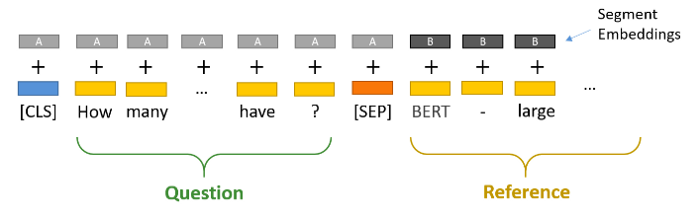

In [25]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b
mask_ids = [1]*len(segment_ids)
# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

>*Side Note: Where's the padding?*
>
> The original [example code](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering) does not perform any padding. I suspect that this is because we are only feeding in a *single example*. If we instead fed in a batch of examples, then we would need to pad or truncate all of the samples in the batch to a single length, and supply an attention mask to tell BERT to ignore the padding tokens. 

We're ready to feed our example into the model!

To fine-tune BERT for a Question-Answering system, it introduces a start vector and an end vector. The probability of each word being the start-word is calculated by taking a dot product between the final embedding of the word and the start vector, followed by a softmax over all the words. The word with the highest probability value is considered.

In [26]:
# Run our example through the model.
outputs = model(input_ids = torch.tensor([input_ids]), # The tokens representing our input text.
                                 attention_mask = torch.tensor([mask_ids]),
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


Now we can highlight the answer just by looking at the most probable start and end words. 

In [27]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(outputs.start_logits)
answer_end = torch.argmax(outputs.start_logits)

# Combine the tokens in the answer and print it out.
answer = ''.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "众"


It got it right! Awesome :)

> *Side Note: It's a little naive to pick the highest scores for start and end--what if it predicts an end word that's before the start word?! The correct implementation is to pick the highest total score for which end >= start.*

With a little more effort, we can reconstruct any words that got broken down into subwords.

In [181]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += '' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "[CLS][UNK]百度[UNK]二字出自哪里？[SEP][UNK]百度[UNK]二字，来自于八百年前南宋词人辛弃疾"


## 4. Visualizing Scores

I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    #用来正常显示负号
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'simhei.ttf',size=14)
 
 

# Use plot styling from seaborn.
sns.set(style='darkgrid',font=myfont.get_name())

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (25,12)

Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [183]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


Create a bar plot showing the score for every input word being the "start" word.

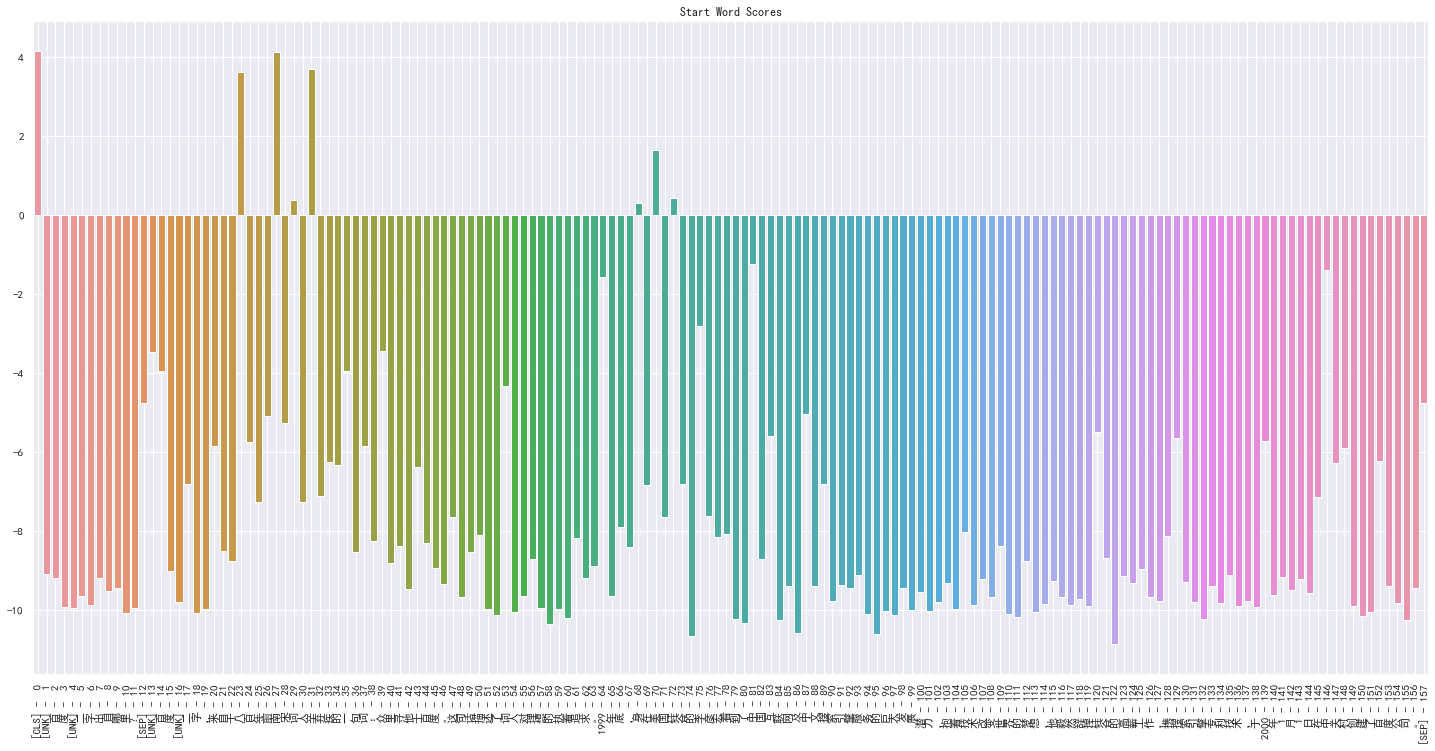

In [184]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

Create a second bar plot showing the score for every input word being the "end" word.

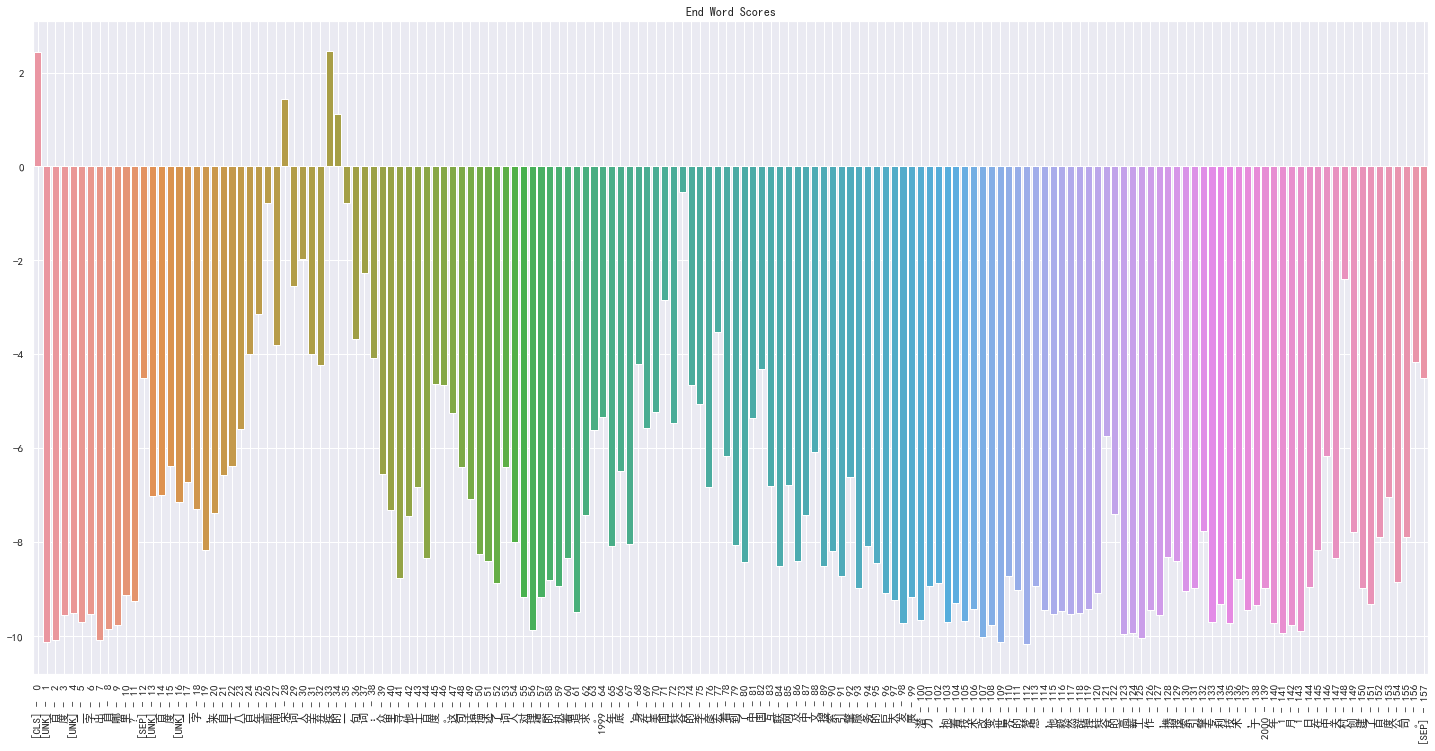

In [185]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

**Alternate View**

I also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately. 

In [186]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


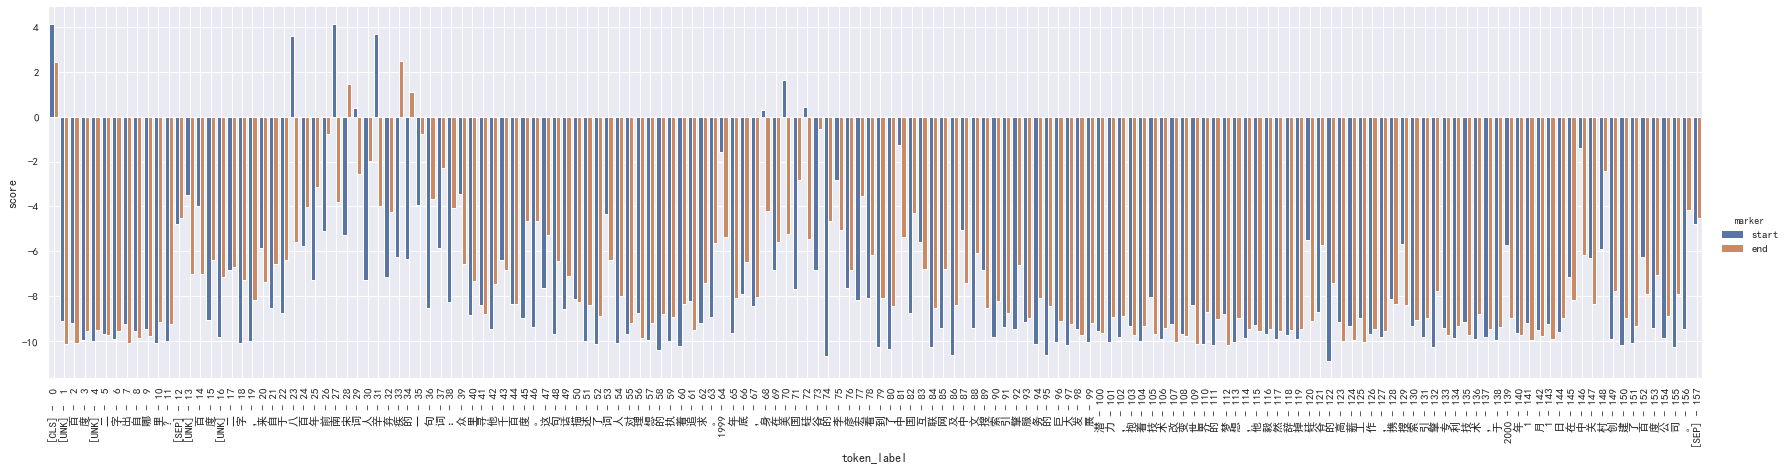

In [187]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


## 5. More Examples

Turn the QA process into a function so we can easily try out other examples.

In [188]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += '' + tokens[i]

    print('Answer: "' + answer + '"')

As our reference text, I've taken the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).


In [189]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = '''内容分析也不应排除定性分析，即根据所得到的材料和数据进行一定的逻辑推理和哲学思辩。
内容分析一般要经过选择、分类、统计等三个阶段，可采取以下3种作法：(一)记录或观察某一传播媒介在某一时期的传播内容;
(二)对同一传播媒介在不同时期所报道的内容进行分析和比较;
(三)对同一时期不同传播媒介就同一事件或同一题材所报道的内容、方式、方法等进行分析和比较，找出异同。'''

print(wrapper.fill(bert_abstract))

内容分析也不应排除定性分析，即根据所得到的材料和数据进行一定的逻辑推理和哲学思辩。
内容分析一般要经过选择、分类、统计等三个阶段，可采取以下3种作法：(一)记录或观察某一传播媒介在某一时期的传播内容;
(二)对同一传播媒介在不同时期所报道的内容进行分析和比较; (三)对同一时期不同传播媒介就同一事件或同一题材所报道的内容、方式、方法等进行分析和比较，找出异同。


In [190]:
question = "内容分析一般经历几个阶段？"

answer_question(question, bert_abstract)

Query has 194 tokens.

Answer: "三"


In [191]:
question = "内容分析一般经历哪些阶段？"

answer_question(question, bert_abstract)

Query has 194 tokens.

Answer: "选择、分类、统计"


In [192]:
question = "内容分析有几种做法？"

answer_question(question, bert_abstract)

Query has 191 tokens.

Answer: "3"


In [ ]:
"""Official evaluation script for SQuAD version 2.0.

In addition to basic functionality, we also compute additional statistics and
plot precision-recall curves if an additional na_prob.json file is provided.
This file is expected to map question ID's to the model's predicted probability
that a question is unanswerable.
"""
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys

OPTS = None

def parse_args():
  parser = argparse.ArgumentParser('Official evaluation script for SQuAD version 2.0.')
  parser.add_argument('data_file', metavar='data.json', help='Input data JSON file.')
  parser.add_argument('pred_file', metavar='pred.json', help='Model predictions.')
  parser.add_argument('--out-file', '-o', metavar='eval.json',
                      help='Write accuracy metrics to file (default is stdout).')
  parser.add_argument('--na-prob-file', '-n', metavar='na_prob.json',
                      help='Model estimates of probability of no answer.')
  parser.add_argument('--na-prob-thresh', '-t', type=float, default=1.0,
                      help='Predict "" if no-answer probability exceeds this (default = 1.0).')
  parser.add_argument('--out-image-dir', '-p', metavar='out_images', default=None,
                      help='Save precision-recall curves to directory.')
  parser.add_argument('--verbose', '-v', action='store_true')
  if len(sys.argv) == 1:
    parser.print_help()
    sys.exit(1)
  return parser.parse_args()

def make_qid_to_has_ans(dataset):
  qid_to_has_ans = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid_to_has_ans[qa['id']] = bool(qa['answers'])
  return qid_to_has_ans

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def get_raw_scores(dataset, preds):
  exact_scores = {}
  f1_scores = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid = qa['id']
        gold_answers = [a['text'] for a in qa['answers']
                        if normalize_answer(a['text'])]
        if not gold_answers:
          # For unanswerable questions, only correct answer is empty string
          gold_answers = ['']
        if qid not in preds:
          print('Missing prediction for %s' % qid)
          continue
        a_pred = preds[qid]
        # Take max over all gold answers
        exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
        f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
  return exact_scores, f1_scores

def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans, na_prob_thresh):
  new_scores = {}
  for qid, s in scores.items():
    pred_na = na_probs[qid] > na_prob_thresh
    if pred_na:
      new_scores[qid] = float(not qid_to_has_ans[qid])
    else:
      new_scores[qid] = s
  return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
  if not qid_list:
    total = len(exact_scores)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores.values()) / total),
        ('f1', 100.0 * sum(f1_scores.values()) / total),
        ('total', total),
    ])
  else:
    total = len(qid_list)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores[k] for k in qid_list) / total),
        ('f1', 100.0 * sum(f1_scores[k] for k in qid_list) / total),
        ('total', total),
    ])

def merge_eval(main_eval, new_eval, prefix):
  for k in new_eval:
    main_eval['%s_%s' % (prefix, k)] = new_eval[k]

def plot_pr_curve(precisions, recalls, out_image, title):
  plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
  plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.title(title)
  plt.savefig(out_image)
  plt.clf()

def make_precision_recall_eval(scores, na_probs, num_true_pos, qid_to_has_ans,
                               out_image=None, title=None):
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  true_pos = 0.0
  cur_p = 1.0
  cur_r = 0.0
  precisions = [1.0]
  recalls = [0.0]
  avg_prec = 0.0
  for i, qid in enumerate(qid_list):
    if qid_to_has_ans[qid]:
      true_pos += scores[qid]
    cur_p = true_pos / float(i+1)
    cur_r = true_pos / float(num_true_pos)
    if i == len(qid_list) - 1 or na_probs[qid] != na_probs[qid_list[i+1]]:
      # i.e., if we can put a threshold after this point
      avg_prec += cur_p * (cur_r - recalls[-1])
      precisions.append(cur_p)
      recalls.append(cur_r)
  if out_image:
    plot_pr_curve(precisions, recalls, out_image, title)
  return {'ap': 100.0 * avg_prec}

def run_precision_recall_analysis(main_eval, exact_raw, f1_raw, na_probs, 
                                  qid_to_has_ans, out_image_dir):
  if out_image_dir and not os.path.exists(out_image_dir):
    os.makedirs(out_image_dir)
  num_true_pos = sum(1 for v in qid_to_has_ans.values() if v)
  if num_true_pos == 0:
    return
  pr_exact = make_precision_recall_eval(
      exact_raw, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_exact.png'),
      title='Precision-Recall curve for Exact Match score')
  pr_f1 = make_precision_recall_eval(
      f1_raw, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_f1.png'),
      title='Precision-Recall curve for F1 score')
  oracle_scores = {k: float(v) for k, v in qid_to_has_ans.items()}
  pr_oracle = make_precision_recall_eval(
      oracle_scores, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_oracle.png'),
      title='Oracle Precision-Recall curve (binary task of HasAns vs. NoAns)')
  merge_eval(main_eval, pr_exact, 'pr_exact')
  merge_eval(main_eval, pr_f1, 'pr_f1')
  merge_eval(main_eval, pr_oracle, 'pr_oracle')

def histogram_na_prob(na_probs, qid_list, image_dir, name):
  if not qid_list:
    return
  x = [na_probs[k] for k in qid_list]
  weights = np.ones_like(x) / float(len(x))
  plt.hist(x, weights=weights, bins=20, range=(0.0, 1.0))
  plt.xlabel('Model probability of no-answer')
  plt.ylabel('Proportion of dataset')
  plt.title('Histogram of no-answer probability: %s' % name)
  plt.savefig(os.path.join(image_dir, 'na_prob_hist_%s.png' % name))
  plt.clf()

def find_best_thresh(preds, scores, na_probs, qid_to_has_ans):
  num_no_ans = sum(1 for k in qid_to_has_ans if not qid_to_has_ans[k])
  cur_score = num_no_ans
  best_score = cur_score
  best_thresh = 0.0
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  for i, qid in enumerate(qid_list):
    if qid not in scores: continue
    if qid_to_has_ans[qid]:
      diff = scores[qid]
    else:
      if preds[qid]:
        diff = -1
      else:
        diff = 0
    cur_score += diff
    if cur_score > best_score:
      best_score = cur_score
      best_thresh = na_probs[qid]
  return 100.0 * best_score / len(scores), best_thresh

def find_all_best_thresh(main_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans):
  best_exact, exact_thresh = find_best_thresh(preds, exact_raw, na_probs, qid_to_has_ans)
  best_f1, f1_thresh = find_best_thresh(preds, f1_raw, na_probs, qid_to_has_ans)
  main_eval['best_exact'] = best_exact
  main_eval['best_exact_thresh'] = exact_thresh
  main_eval['best_f1'] = best_f1
  main_eval['best_f1_thresh'] = f1_thresh

def main():
  with open(OPTS.data_file) as f:
    dataset_json = json.load(f)
    dataset = dataset_json['data']
  with open(OPTS.pred_file) as f:
    preds = json.load(f)
  if OPTS.na_prob_file:
    with open(OPTS.na_prob_file) as f:
      na_probs = json.load(f)
  else:
    na_probs = {k: 0.0 for k in preds}
  qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
  has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
  no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
  exact_raw, f1_raw = get_raw_scores(dataset, preds)
  exact_thresh = apply_no_ans_threshold(exact_raw, na_probs, qid_to_has_ans,
                                        OPTS.na_prob_thresh)
  f1_thresh = apply_no_ans_threshold(f1_raw, na_probs, qid_to_has_ans,
                                     OPTS.na_prob_thresh)
  out_eval = make_eval_dict(exact_thresh, f1_thresh)
  if has_ans_qids:
    has_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=has_ans_qids)
    merge_eval(out_eval, has_ans_eval, 'HasAns')
  if no_ans_qids:
    no_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=no_ans_qids)
    merge_eval(out_eval, no_ans_eval, 'NoAns')
  if OPTS.na_prob_file:
    find_all_best_thresh(out_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans)
  if OPTS.na_prob_file and OPTS.out_image_dir:
    run_precision_recall_analysis(out_eval, exact_raw, f1_raw, na_probs, 
                                  qid_to_has_ans, OPTS.out_image_dir)
    histogram_na_prob(na_probs, has_ans_qids, OPTS.out_image_dir, 'hasAns')
    histogram_na_prob(na_probs, no_ans_qids, OPTS.out_image_dir, 'noAns')
  if OPTS.out_file:
    with open(OPTS.out_file, 'w') as f:
      json.dump(out_eval, f)
  else:
    print(json.dumps(out_eval, indent=2))

if __name__ == '__main__':
  OPTS = parse_args()
  if OPTS.out_image_dir:
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt 
  main()
